# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

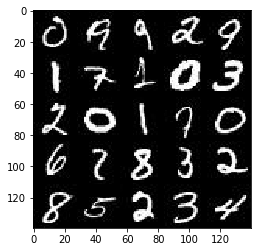

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

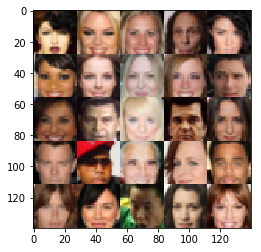

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None,z_dim), name="input_z")
    learning_rate = tf.placeholder(dtype = tf.float32, name="learning_rate")                            
                             

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/tensorflow-1.1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    dropout = 0.15
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 x #channels
        # Layer 1, no batch norm on first layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate=dropout, training=True)
        x2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=dropout, training=True)
        x3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4 x 4 x 256

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        # One output unit
        logits = tf.layers.dense(flat,1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
   
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
        
    alpha = 0.2
    dropout = 0.15
    with tf.variable_scope('generator', reuse=not is_train):
    
        # Output should be 28 x 28 x out_channels
        x1 = tf.layers.dense(z, 7 * 7 * 512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1,(-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.dropout(x2, rate=dropout, training=is_train)
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.dropout(x3, rate=dropout, training=is_train)
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128
         
        # Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    generator_model = generator(input_z, out_channel_dim)
    discriminator_real, discriminator_real_logits = discriminator(input_real)
    discriminator_fake, discriminator_fake_logits = discriminator(generator_model, reuse=True)
  
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real )*(1 - smooth) ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss , g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:

class GAN:
    def __init__(self, real_size, z_dim, data_image_mode, beta1=0.5):
                   
        image_width = real_size[1]
        image_height = real_size[2]
        channels = real_size[3]

        self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height,channels, z_dim)

        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,  channels)
       
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    net = GAN(data_shape, z_dim, data_image_mode)

    steps = 0

    print_every = 10
    show_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
   
                steps += 1
                # images are in range -0.5;0.5
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    channels = data_shape[3]
                    show_generator_output(sess,25, net.input_z, channels,data_image_mode)
        
        print("Final output")
        channels = data_shape[3]
        show_generator_output(sess,25, net.input_z, channels,data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3872... Generator Loss: 7.5516
Epoch 1/2... Discriminator Loss: 0.4700... Generator Loss: 5.4822
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 2.0556
Epoch 1/2... Discriminator Loss: 2.1865... Generator Loss: 4.0126
Epoch 1/2... Discriminator Loss: 1.6270... Generator Loss: 3.5729


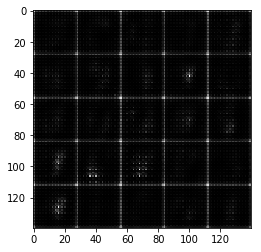

Epoch 1/2... Discriminator Loss: 2.6706... Generator Loss: 0.2016
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 2.2435
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.9399


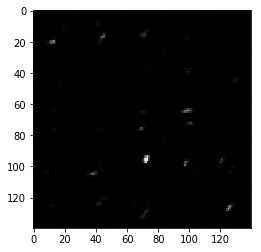

Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 1.2000... Generator Loss: 1.6709
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.9035... Generator Loss: 2.8027
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.9298


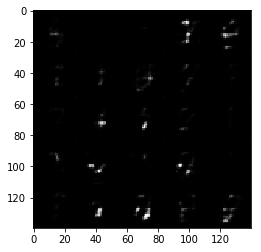

Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 1.4057
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 1.3778
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 1.2114


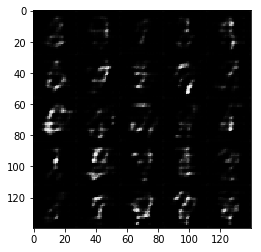

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 1.1536
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 1.4554
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 1.3908


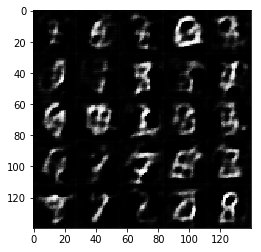

Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 1.4083
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.6214


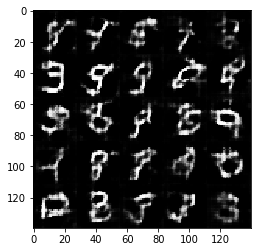

Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.1519
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 1.0047


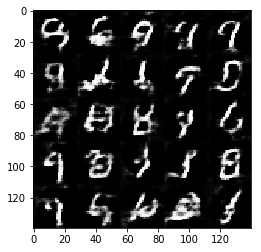

Epoch 1/2... Discriminator Loss: 1.2329... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 1.1970
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 1.3481
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.5355


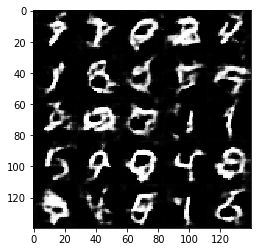

Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.8335
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 1.6869
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.6816


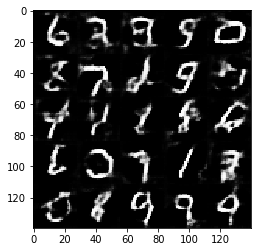

Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.3139
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 1.4140
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.1689


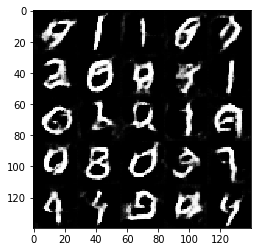

Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.1741
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 1.0479


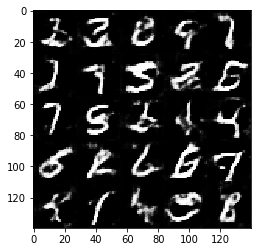

Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 1.2309
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.7307


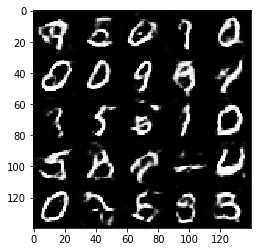

Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.5225


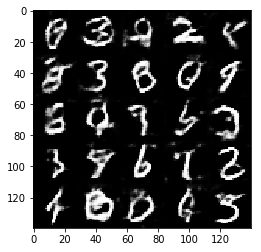

Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 1.2616
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.8473


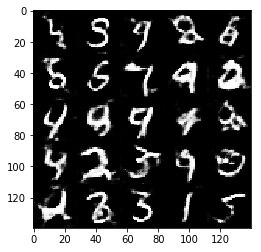

Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 1.2189
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 1.2568
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9262


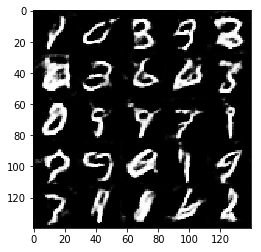

Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.5926
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.6397
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.5492
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.8160


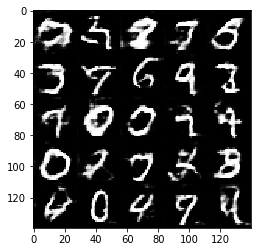

Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.0638
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 1.1047
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.7725


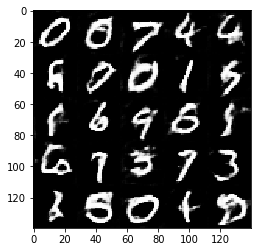

Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.8291


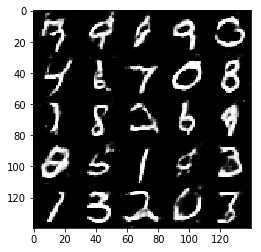

Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 1.5189


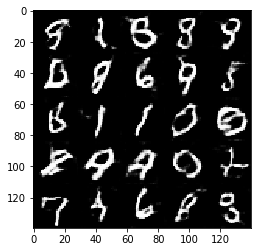

Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.5490
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 1.0714
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 0.9681
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.7126


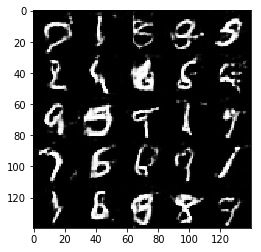

Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 1.3430
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 1.1268
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 1.1241


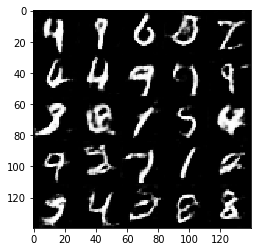

Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 1.1391
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 1.2163
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 1.1445
Epoch 2/2... Discriminator Loss: 1.5910... Generator Loss: 0.4255


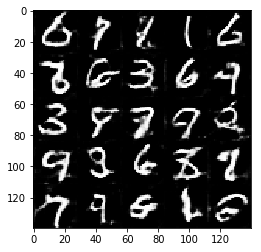

Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.1066
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 1.2130
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.7629


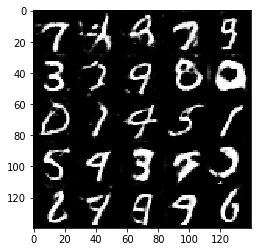

Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 0.8772


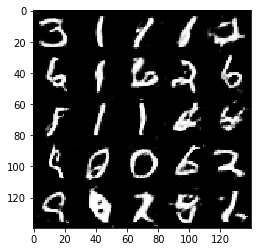

Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 1.0977
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.1570


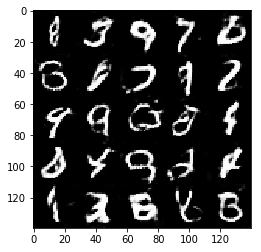

Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 1.4783


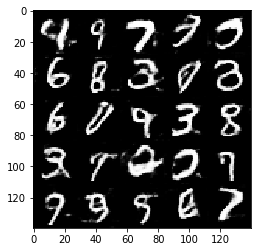

Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 1.1126
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 1.1259


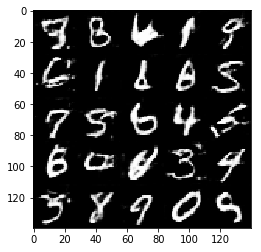

Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.5005
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.5810


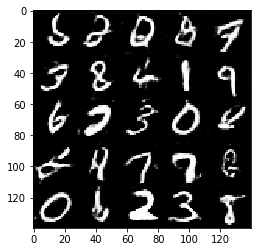

Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 1.8918
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 1.3906
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 1.7709


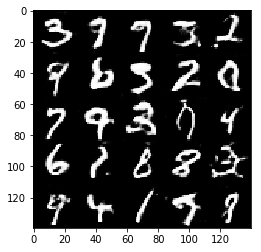

Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 0.9692... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 1.6377... Generator Loss: 2.1783
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 1.2163
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 1.0193


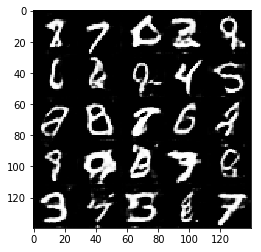

Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.8200
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 1.3629


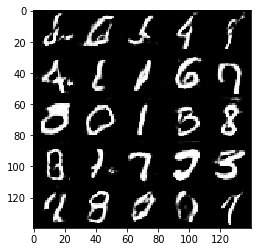

Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.1347
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.2141


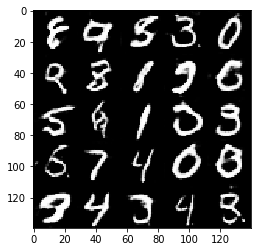

Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.0858
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 1.7455
Epoch 2/2... Discriminator Loss: 1.5259... Generator Loss: 2.8829
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.2624
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.9809


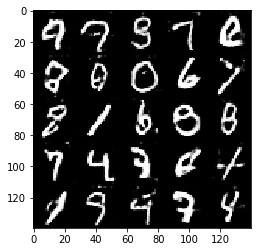

Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 2.0110
Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.3227


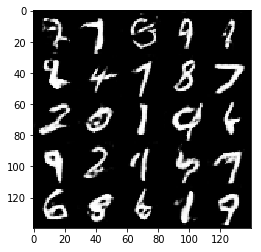

Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.0227
Epoch 2/2... Discriminator Loss: 2.1232... Generator Loss: 3.1504
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 1.8070


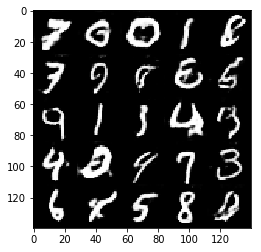

Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 0.9648... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.3033
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.1101


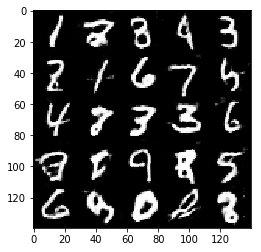

Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 2.0320
Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 1.4091
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 1.3515


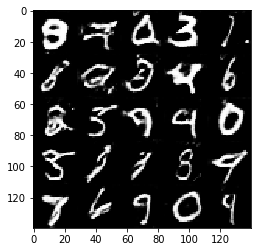

Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.9823
Final output


NameError: name 'get_channels' is not defined

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.7819
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 3.8044... Generator Loss: 0.0944
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.8846


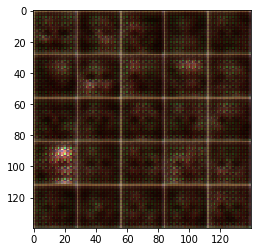

Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.6639
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.9440
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 3.7241


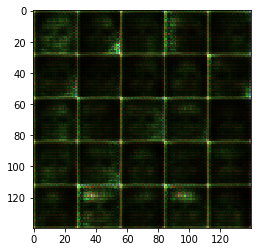

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 5.1320
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 4.8295
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 3.2563


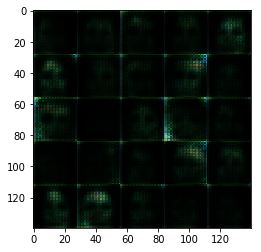

Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.8072... Generator Loss: 2.2396
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 1.7815
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.4463


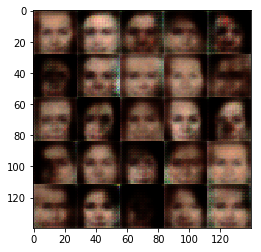

Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 1.4543
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.2961


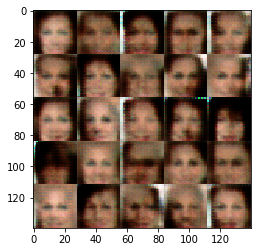

Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 2.0008
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.6840


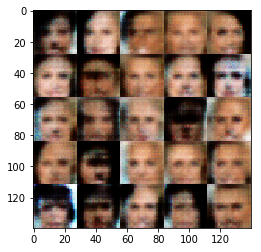

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 2.5855
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.0624


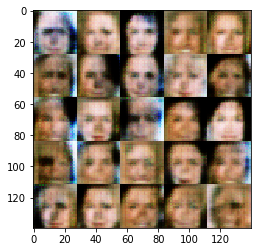

Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.7629


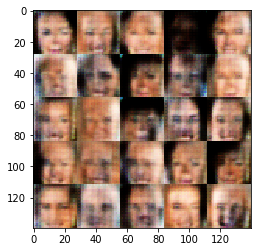

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.4000


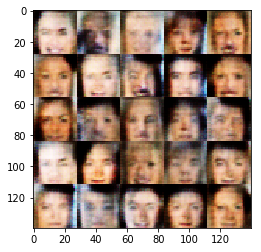

Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 2.0114
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8938


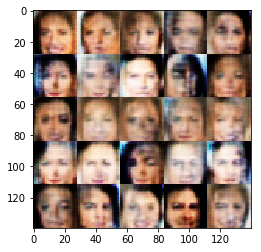

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.7939


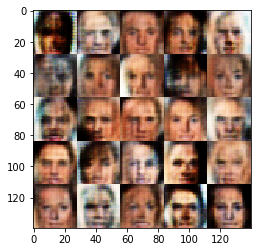

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8289


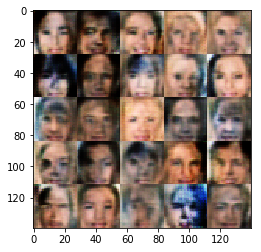

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.2004


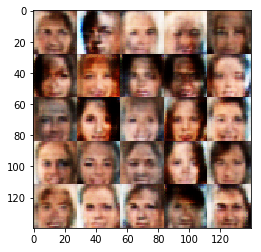

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 2.0065
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9509


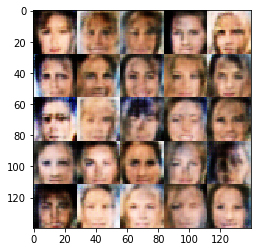

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.3645


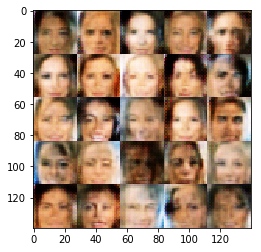

Epoch 1/1... Discriminator Loss: 1.6215... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8008


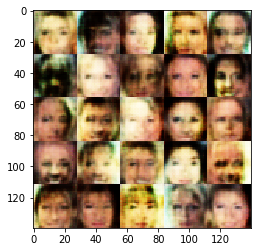

Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5778


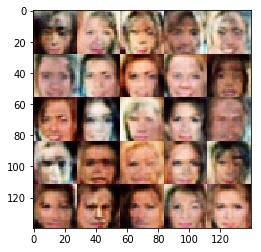

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9287


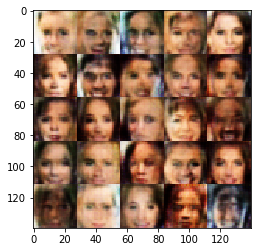

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6489


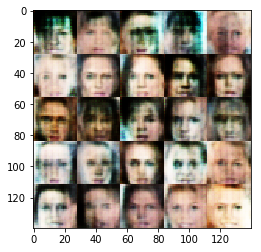

Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8600


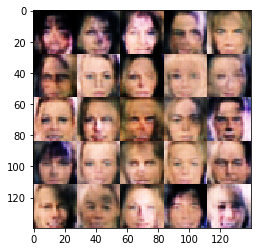

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.5168


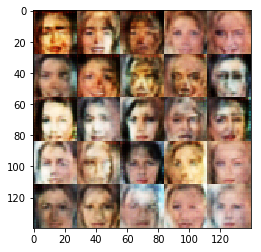

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7733


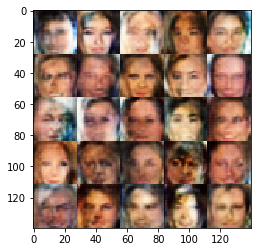

Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6844


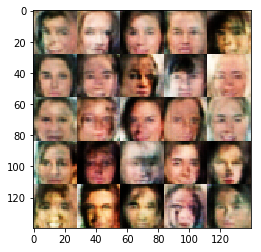

Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7464


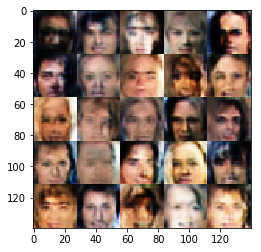

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8239


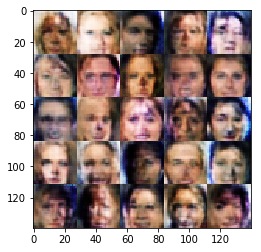

Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8712


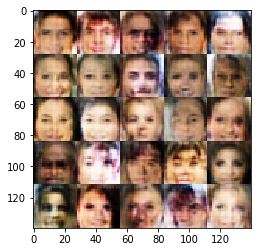

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8209


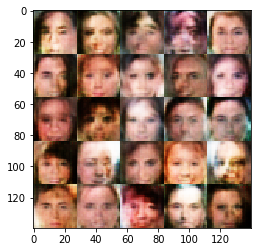

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.6069


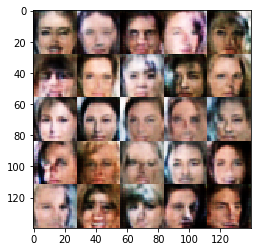

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8123


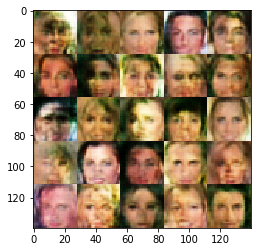

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.6379


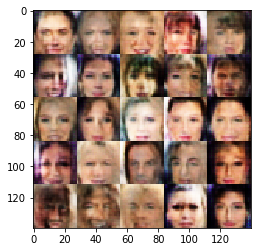

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7760


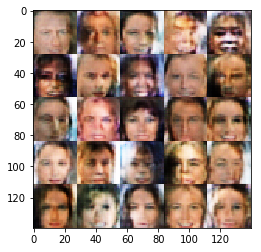

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 1.1513


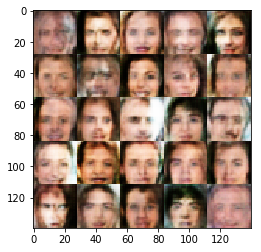

Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8271


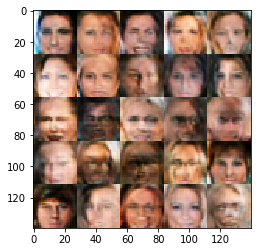

Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7689


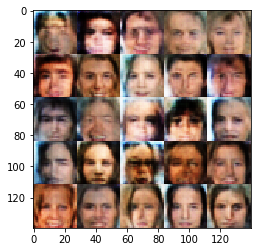

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7735


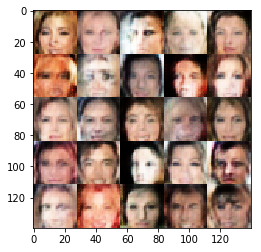

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.0616


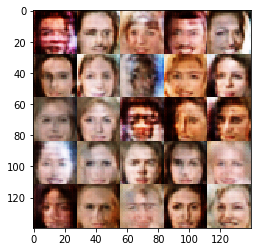

Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6350


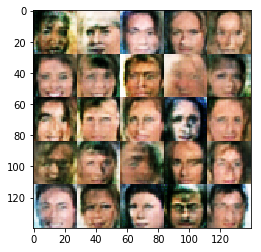

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.5666


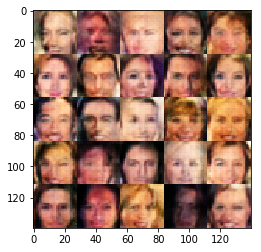

Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7774


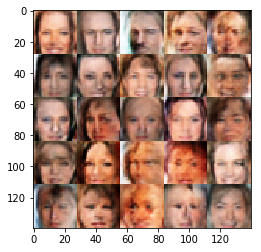

Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8086


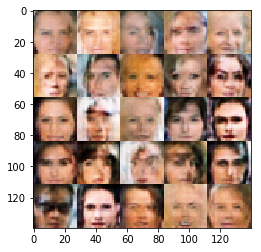

Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9059


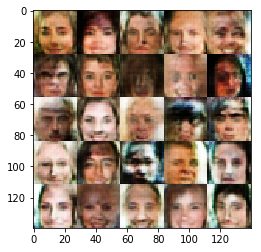

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.0095


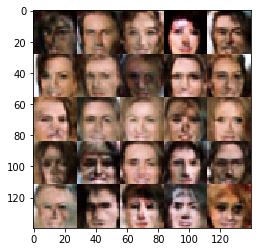

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7814


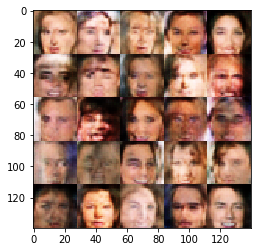

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7338


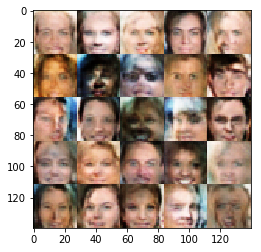

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7910


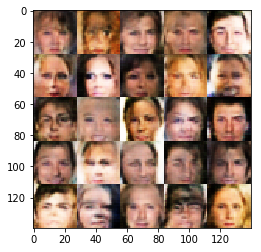

Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8854


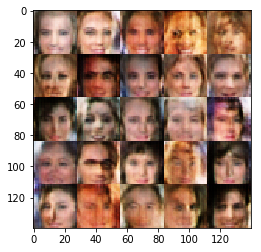

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.9928


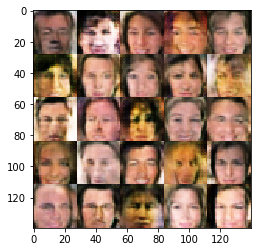

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7595


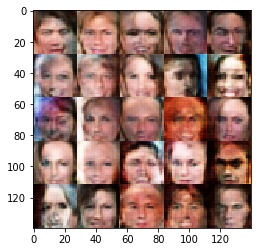

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6447


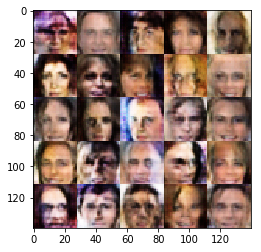

Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.0389


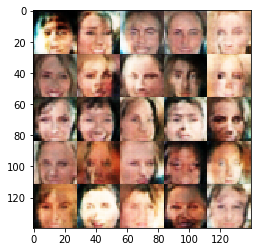

Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8502


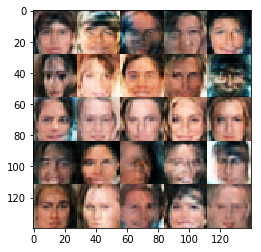

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7291


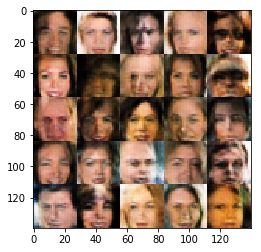

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7257


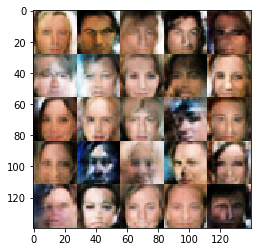

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7165


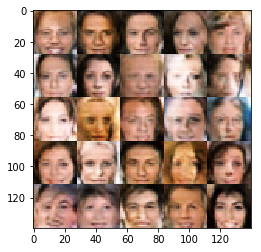

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8442


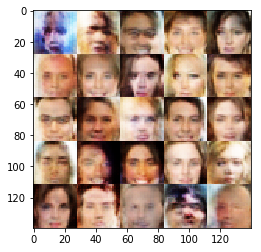

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 1.0152


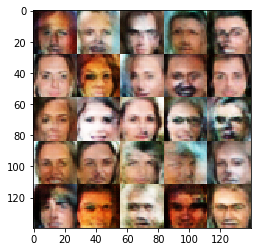

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.7190


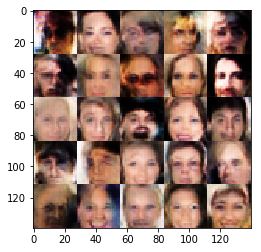

Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7669


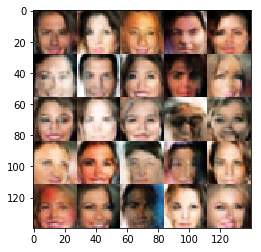

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7841


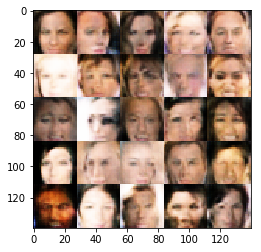

Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7198


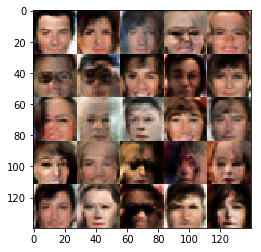

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8860


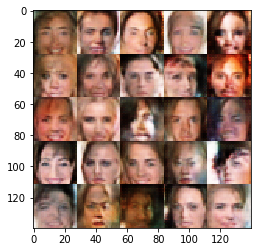

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.9346


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.